In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
import threading
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\Obfuscated-MalMem2022\\Obfuscated-MalMem2022.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

In [4]:
#Feature Selection
features_to_drop = ['Category', 'Class']

# Droping specified columns and target variable
X = DM.drop(features_to_drop, axis=1).values    
y = DM['Class'].values

In [5]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
# Applying Min-Max scaling to make X non-negative
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
rfe_selector.fit(X_scaled, y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=5)

In [8]:
# Get top features selected by RFE
rfe_top_features_indices = np.where(rfe_selector.support_)[0]

# Retrieve names of the selected features
filtered_columns = DM.drop(features_to_drop, axis=1).columns
features = [filtered_columns[idx] for idx in rfe_top_features_indices]

# Output the selected features and their ranking
print("Selected Features using RFE:")
for feature, rank in zip(features, rfe_selector.ranking_[rfe_top_features_indices]):
    print(f"Feature: {feature} - RFE Rank: {rank}")

Selected Features using RFE:
Feature: dlllist.avg_dlls_per_proc - RFE Rank: 1
Feature: handles.nmutant - RFE Rank: 1
Feature: svcscan.nservices - RFE Rank: 1
Feature: svcscan.kernel_drivers - RFE Rank: 1
Feature: svcscan.shared_process_services - RFE Rank: 1


In [9]:
# Memilih 100% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('Class').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)
hasil_threshold = []

In [10]:
def Thresholding(threshold, feature):
    # Mengukur waktu mulai
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Class"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malware"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Class"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp / (tp + fp) if (tp + fp) != 0 else 0
    RecallThreshold = tp / (tp + fn) if (tp + fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold * RecallThreshold) / (PrecisionThreshold + RecallThreshold)) if (PrecisionThreshold + RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0

    # Mengukur waktu selesai
    elapsed_time = time.time() - start_time

    # Menyimpan hasil dalam format satu baris untuk setiap threshold
    hasil_threshold.append([feature, threshold, PrecisionThreshold, RecallThreshold, F1ScoreThreshold, AccuracyThreshold, elapsed_time])

# Lakukan thresholding pada fitur yang dipilih oleh Chi-Square Test
for feature in tqdm(features, desc='Progress'):
    # Pastikan bahwa Min dan Max adalah nilai numerik
    Max = pd.to_numeric(sampled_data[feature], errors='coerce').max()
    Min = pd.to_numeric(sampled_data[feature], errors='coerce').min()

    # Cek apakah Min dan Max valid (bukan NaN)
    if pd.notna(Min) and pd.notna(Max):
        for x in range(int(Min), int(Max + 1)):
            Thresholding(x, feature)
    else:
        print(f"Fitur {feature} mengandung nilai non-numerik dan tidak dapat diproses.")

print(hasil_threshold)

# Mengubah hasil menjadi DataFrame dengan kolom yang sesuai
hasil_threshold_df = pd.DataFrame(hasil_threshold, columns=['Feature', 'Threshold', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'Elapsed_Time'])

# Simpan DataFrame ke CSV
hasil_threshold_df.to_csv('Recursive Feature Elimination.csv', index=False)

print("Hasil threshold disimpan ke dalam file 'Recursive Feature Elimination.csv'")

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [03:32<00:00, 42.56s/it]

[['dlllist.avg_dlls_per_proc', 7, 0.0, 0, 0, 0.5, 0.17656254768371582], ['dlllist.avg_dlls_per_proc', 8, 3.413202266366305e-05, 1.0, 6.826171541690844e-05, 0.5000170660113318, 0.15108633041381836], ['dlllist.avg_dlls_per_proc', 9, 0.0001365280906546522, 1.0, 0.00027301890655927923, 0.5000682640453273, 0.17929434776306152], ['dlllist.avg_dlls_per_proc', 10, 0.00040958427196395656, 1.0, 0.000818833162743091, 0.500204792135982, 0.19061779975891113], ['dlllist.avg_dlls_per_proc', 11, 0.0006485084306095979, 1.0, 0.0012961762799740765, 0.5003242542153048, 0.18187546730041504], ['dlllist.avg_dlls_per_proc', 12, 0.0008874325892552393, 1.0, 0.0017732915018414952, 0.5004437162946276, 0.1899855136871338], ['dlllist.avg_dlls_per_proc', 13, 0.0010239606799098914, 1.0, 0.0020458265139116204, 0.5005119803399549, 0.17096686363220215], ['dlllist.avg_dlls_per_proc', 14, 0.0011946207932282066, 1.0, 0.002386390754440391, 0.5005973103966141, 0.21380209922790527], ['dlllist.avg_dlls_per_proc', 15, 0.0012970

In [11]:
HasilThreshold = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\02-10-2024\\Recursive Feature Elimination.csv")
HasilThreshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Feature       1076 non-null   object 
 1   Threshold     1076 non-null   int64  
 2   Precision     1076 non-null   float64
 3   Recall        1076 non-null   float64
 4   F1_Score      1076 non-null   float64
 5   Accuracy      1076 non-null   float64
 6   Elapsed_Time  1076 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 59.0+ KB


In [12]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = ['', '', 0]  # [feature, threshold, value]
winner_recall = ['', '', 0]
winner_f1_score = ['', '', 0]
winner_accuracy = ['', '', 0]
winner_run_time = ['', '', float('inf')]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

# Iterasi melalui setiap baris di HasilThreshold
for index, result in HasilThreshold.iterrows():
    # result['Feature'], result['Threshold'], result['Precision'], 
    # result['Recall'], result['F1_Score'], result['Accuracy'],
    # result['Elapsed_Time']
    
    # Membandingkan Precision
    if result['Precision'] > winner_precision[2]:  # result['Precision']
        winner_precision = [result['Feature'], result['Threshold'], result['Precision']]  # [feature, threshold, Precision]
    
    # Membandingkan Recall
    if result['Recall'] > winner_recall[2]:  # result['Recall']
        winner_recall = [result['Feature'], result['Threshold'], result['Recall']]  # [feature, threshold, Recall]

    # Membandingkan F1-score
    if result['F1_Score'] > winner_f1_score[2]:  # result['F1_Score']
        winner_f1_score = [result['Feature'], result['Threshold'], result['F1_Score']]  # [feature, threshold, F1 Score]

    # Membandingkan Accuracy
    if result['Accuracy'] > winner_accuracy[2]:  # result['Accuracy']
        winner_accuracy = [result['Feature'], result['Threshold'], result['Accuracy']]  # [feature, threshold, Accuracy]

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result['Elapsed_Time'] < winner_run_time[2]:  # result['Elapsed_Time']
        winner_run_time = [result['Feature'], result['Threshold'], result['Elapsed_Time']]  # [feature, threshold, elapsed_time]

In [13]:
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds = winner_results['Threshold'].tolist()  # Threshold
    precision = winner_results['Precision'].tolist()   # Precision
    recall = winner_results['Recall'].tolist()         # Recall
    f1_score = winner_results['F1_Score'].tolist()     # F1 Score
    accuracy = winner_results['Accuracy'].tolist()      # Accuracy

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='o')
    plt.plot(thresholds, f1_score, label='F1 Score', marker='o')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds = winner_results['Threshold'].tolist()    # Threshold
    run_time = winner_results['Elapsed_Time'].tolist()   # Run Time (elapsed_time)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time', marker='o')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

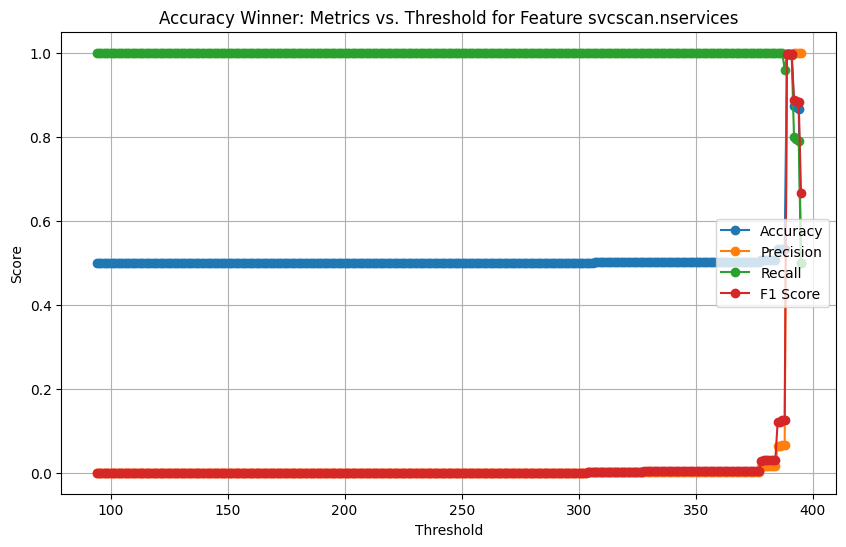

In [15]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

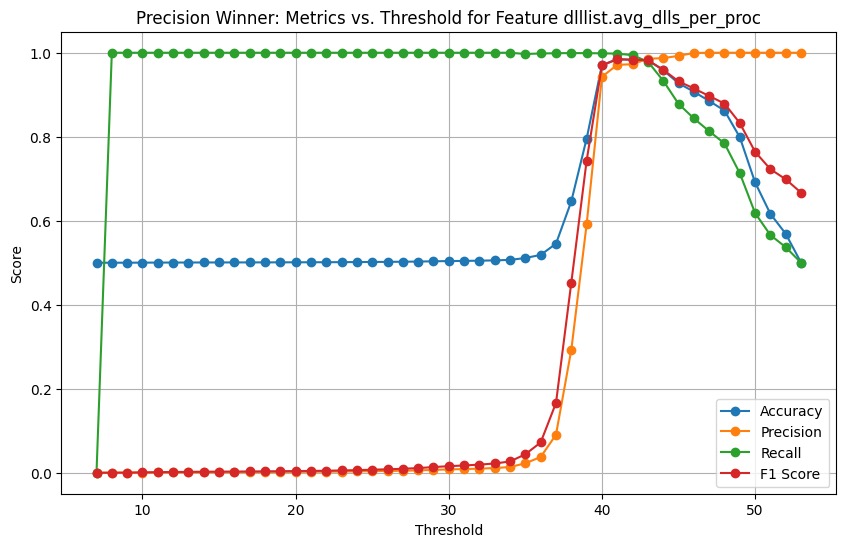

In [16]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

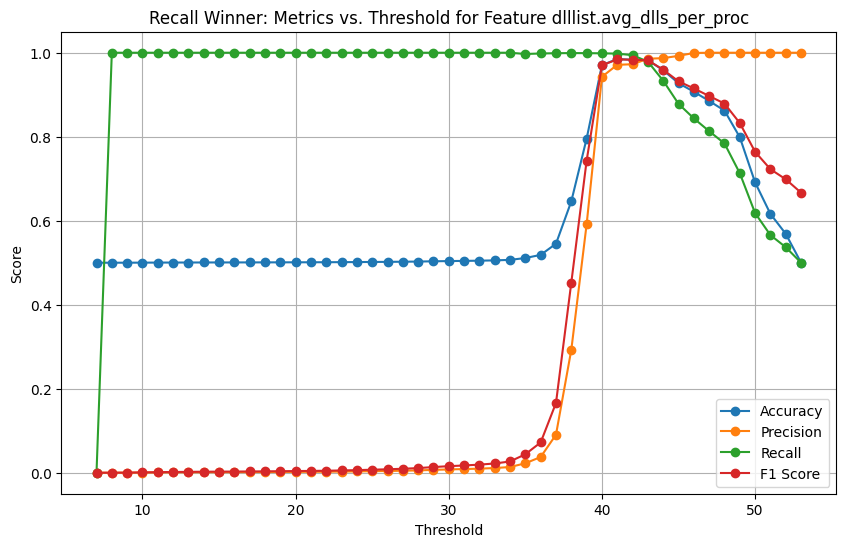

In [17]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

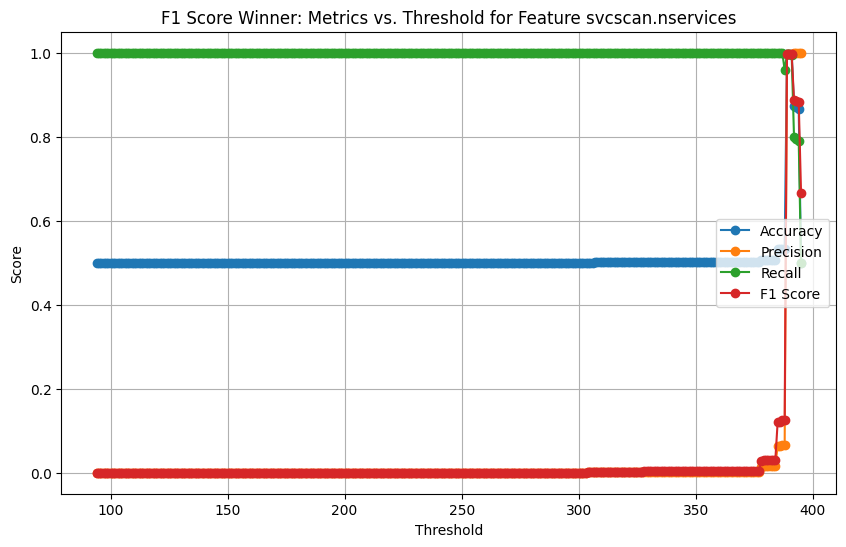

In [18]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

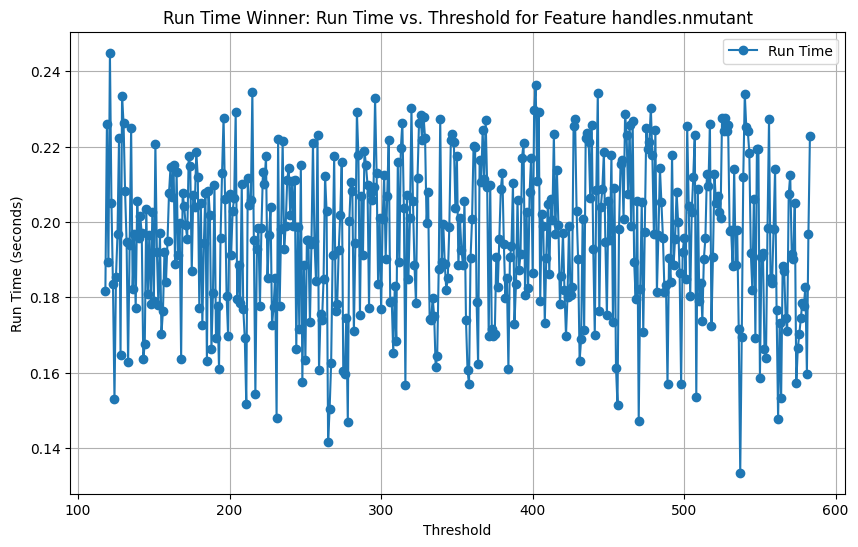

In [19]:
# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [20]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0]} dan threshold {winner_precision[1]}, menghasilkan precision {winner_precision[2]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0]} dan threshold {winner_recall[1]}, menghasilkan recall {winner_recall[2]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0]} dan threshold {winner_f1_score[1]}, menghasilkan F1-score {winner_f1_score[2]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0]} dan threshold {winner_accuracy[1]}, menghasilkan akurasi {winner_accuracy[2]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0]} dan threshold {winner_run_time[1]}, dengan waktu running {winner_run_time[2]} detik.")

Precision terbaik dicapai dengan fitur dlllist.avg_dlls_per_proc dan threshold 47, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur dlllist.avg_dlls_per_proc dan threshold 8, menghasilkan recall 1.0.
F1-score terbaik dicapai dengan fitur svcscan.nservices dan threshold 390, menghasilkan F1-score 0.9966236955187232.
Akurasi terbaik dicapai dengan fitur svcscan.nservices dan threshold 390, menghasilkan akurasi 0.9966209297562972.
Waktu running tercepat dicapai dengan fitur handles.nmutant dan threshold 537, dengan waktu running 0.1334686279296875 detik.
